## Animate distribution of latents in a VAE

* This notebook is a simple demonstration of how the distribution of latents in a VAE changes as the model trains
* Trained on MNIST dataset
* latent distribution is visualized in a £D plot, with digit class labels

In [1]:
import torch
import numpy as np

# May need run this to change dir to the root of the project
import os
os.chdir('../../../')

from experiments.vae.vae import VAE, VAEConfig, set_seeds, RESOURCES

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as ani

%matplotlib widget

[experiments.base] [INFO] Added console handler
[experiments.base] [INFO] Resources path: /home/akashg/git/NNs-and-Deep-Learning/experiments/../resources
[experiments.base] [INFO] Torch device: cpu


In [2]:
save_path = RESOURCES / "models" / "vae" / "20240819-220600l3_e2" / "z_dist"
assert save_path.exists()

In [3]:
# iterate over files in alphabetical order starting with "labels"

label_list: list[torch.Tensor] = []
z_mu_list: list[torch.Tensor] = []

for file in sorted(save_path.iterdir()):
    if "labels" in file.name:
        labels = torch.load(file, map_location=torch.device("cpu"))
        label_list.append(labels)
    elif "z_mu" in file.name:
        z_mu = torch.load(file, map_location=torch.device("cpu"))
        z_mu_list.append(z_mu)

len(label_list), len(z_mu_list)

(314, 314)

In [4]:
labels = np.array(label_list[0])
labels

array([7, 2, 1, ..., 4, 5, 6])

In [5]:
digit_z_mus = [np.stack([z_mu[labels == digit] for z_mu in z_mu_list]) for digit in range(10)]
len(digit_z_mus), [len(digit_z_mu) for digit_z_mu in digit_z_mus]

(10, [314, 314, 314, 314, 314, 314, 314, 314, 314, 314])

In [6]:
digit_z_mus[1].shape

(314, 1135, 3)

In [7]:
# numpy array of string from 0 to 9
layout = np.array([str(digit) for digit in range(10)]).reshape(5, 2)
layout.tolist()

[['0', '1'], ['2', '3'], ['4', '5'], ['6', '7'], ['8', '9']]

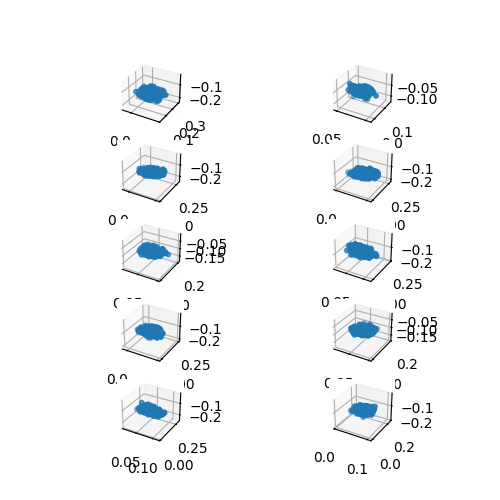

In [8]:
# 3D plot of the latent space

fig, axd = plt.subplot_mosaic(
    layout, subplot_kw=dict(projection="3d"), figsize=(5, 5)
)

timestep = 0

for digit in range(10):
    z_mus = digit_z_mus[digit]
    ax = axd[str(digit)]

    z_mu = z_mus[timestep]
    ax.scatter(z_mu[:, 0], z_mu[:, 1], z_mu[:, 2], s=10)

    # ax.set_xlabel("z1")
    # ax.set_ylabel("z2")
    # ax.set_zlabel("z3")

plt.show()

# ax = fig.add_subplot(111, projection="3d")

# timestep = -1
# z_mu = z_mus[timestep]
# ax.scatter(z_mu[:, 0], z_mu[:, 1], z_mu[:, 2], s=10)

# ax.set_xlabel("z1")
# ax.set_ylabel("z2")
# ax.set_zlabel("z3")

# plt.show()

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


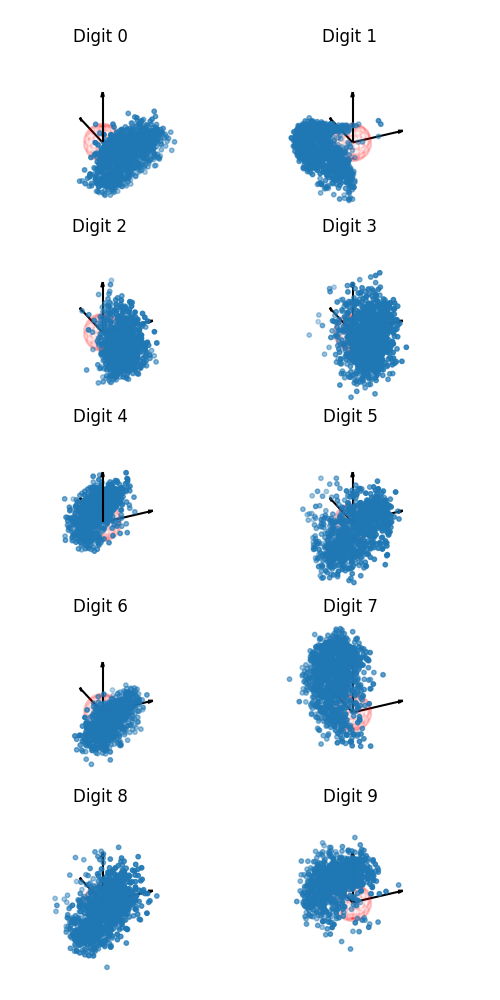

In [48]:
fig, axd = plt.subplot_mosaic(layout, subplot_kw=dict(projection="3d"), figsize=(5, 10))
# plt.tight_layout()

timestep = 0
graphs = []

LIM = (-3, 3)
origin = (0, 0, 0)

# Create a sphere
u, v = np.mgrid[0 : 2 * np.pi : 20j, 0 : np.pi : 10j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)

for digit in range(10):
    z_mus = digit_z_mus[digit]
    ax = axd[str(digit)]
    ax.set_aspect("equal")

    z_mu = z_mus
    g = ax.scatter(z_mu[:, :, 0], z_mu[:, :, 1], z_mu[:, :, 2], s=10)
    graphs.append(g)

    ax.set_xlim(LIM)
    ax.set_ylim(LIM)
    ax.set_zlim(LIM)

    # Do not display ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    ax.set_title(f"Digit {digit}")

    # for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    #     axis.line.set_linewidth(0)

    # Remove the entire axis
    ax.set_axis_off()

    # put quiver instead

    quiver_kwargs = dict(
        length=3,
        arrow_length_ratio=0.1,
        color="k",
        pivot="tail",
        normalize=True,
    )

    ax.quiver(*origin, 1, 0, 0, **quiver_kwargs)
    ax.quiver(*origin, 0, 1, 0, **quiver_kwargs)
    ax.quiver(*origin, 0, 0, 1, **quiver_kwargs)

    ax.set_facecolor("white")

    # draw sphere
    ax.plot_wireframe(x, y, z, color="r", alpha=0.1)


def update(timestep):
    for digit in range(10):
        z_mus = digit_z_mus[digit]

        z_mu = z_mus[timestep]
        graphs[digit]._offsets3d = (z_mu[:, 0], z_mu[:, 1], z_mu[:, 2])

        ax = axd[str(digit)]

        ax.view_init(elev=30, azim=timestep * 5)

    return graphs

plt.subplots_adjust(left=-0.3, right=1.2, top=0.95, bottom=0, wspace=-0.5, hspace=0.)

anim = ani.FuncAnimation(fig, update, frames=range(50), blit=True, interval=100)
anim.save(
    "/home/akashg/git/NNs-and-Deep-Learning/experiments/vae/vis/latent_space.gif",
    writer="imagemagick",
    fps=10,
)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


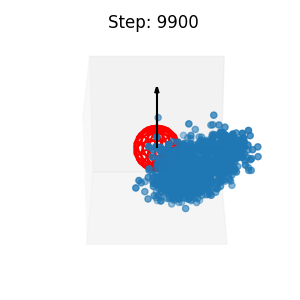

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:207: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:207: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:207: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


TypeError: any() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (tuple of ints dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [30]:
# Animate the latent space, one frame per timestep

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection="3d")
ax.set_aspect("equal")

timestep = 0
z_mu = z_mus[timestep]
g = ax.scatter(z_mu[:, 0], z_mu[:, 1], z_mu[:, 2])

lim = (-3, 3)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_zlim(lim)

# Do not display ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.line.set_linewidth(0)

# put quiver instead

quiver_kwargs = dict(
    length=3,
    arrow_length_ratio=0.1,
    color="k",
    pivot="tail",
    normalize=True,
)

ax.quiver(*origin, 1, 0, 0, **quiver_kwargs)
ax.quiver(*origin, 0, 1, 0, **quiver_kwargs)
ax.quiver(*origin, 0, 0, 1, **quiver_kwargs)

ax.set_facecolor("white")

frames = len(z_mus)

# draw sphere
u, v = np.mgrid[0 : 2 * np.pi : 20j, 0 : np.pi : 10j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_wireframe(x, y, z, color="r")


def next_ani(i):
    ax.set_title(f"Step: {i*100:04d}")
    z_mu = z_mus[i]
    g._offsets3d = (z_mu[:, 0], z_mu[:, 1], z_mu[:, 2])
    ax.view_init(elev=30, azim=i * 10)
    return (g,)


# ax.set_xlabel('z1')
# ax.set_ylabel('z2')
# ax.set_zlabel('z3')

anim = ani.FuncAnimation(fig, next_ani, frames=range(100), blit=True, interval=100)
anim.save(
    "/home/akashg/git/NNs-and-Deep-Learning/experiments/vae/vis/latent_space.gif",
    writer="imagemagick",
    fps=25,
)

In [81]:
x.min()

-0.9713762588622279